<a href="https://colab.research.google.com/github/nebulous05/influence-functions-pytorch/blob/main/revised_IF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.autograd import grad
from torch.utils.data import Subset

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
def create_mnist_dataset(path):
    from torchvision import datasets, transforms

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ],
    )
    dataset_train = datasets.MNIST(path, train=True, download=True, transform=transform)
    dataset_test = datasets.MNIST(path, train=False, download=True, transform=transform)

    return dataset_train, dataset_test

training_set, dataset_test = create_mnist_dataset('./data')
dataset_train, dataset_val = random_split(training_set, [55000, 5000])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 53438461.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2610739.32it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12758723.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1826162.65it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class LogisticRegressionMnist(nn.Module):
    """A simple logistic regression model for MNIST dataset."""

    def __init__(self) -> None:
        super(LogisticRegressionMnist, self).__init__()
        self.linear = nn.Linear(28 * 28, 10, bias=False)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten the image
        return self.linear(x)

In [6]:
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False)

In [7]:
def train(model, epochs, lr, train_loader):
    ''' returns a trained mnist_lr model '''
    # set seeds to make the training process more deterministic
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0.01)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")

torch.manual_seed(42)
model = LogisticRegressionMnist()
train(model, 5, 0.01, train_loader)


Epoch 1/5, Loss: 0.37933207960683396
Epoch 2/5, Loss: 0.3129427697018673
Epoch 3/5, Loss: 0.30474815194653765
Epoch 4/5, Loss: 0.3014292686927355
Epoch 5/5, Loss: 0.2998003072856799


In [8]:
# some functions to retrieve/view data
def get_item(index, dataset='train'):
    ''' returns a pair (image_tensor, label_int) '''
    if dataset == 'train':
        return dataset_train[index]
    elif dataset == 'test':
        return dataset_test[index]

def show_image(index, dataset='train'):
    ''' show an image with matplotlib '''
    if dataset == 'train':
        img = dataset_train[index][0].numpy().reshape(28, 28)
    elif dataset == 'test':
        img = dataset_test[index][0].numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [9]:
# find all misclassified test points
def find_misclassified_indices(model, dataset_test=dataset_test):
  ''' returns a list of indices of all incorrectly labeled test points '''
  model.eval()
  indices = []
  for i in range(len(dataset_test)):
    image, label = get_item(i, dataset='test')
    with torch.no_grad():
      outputs = model(image)
      _, predicted = torch.max(outputs, 1)
      if predicted != label:
        indices.append(i)
  return indices

misclassified_indices = find_misclassified_indices(model)
print(random.choice(misclassified_indices))

7850


predicted: tensor([8])
label: 5


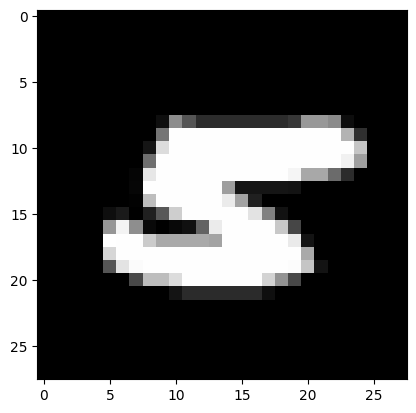

In [10]:
z_test = dataset_test[7850][0]
z_test_label = dataset_test[7850][1]

outputs = model(z_test)
_, predicted = torch.max(outputs, 1)
print("predicted:", predicted)
print("label:", z_test_label)
show_image(7850, dataset='test')

In [11]:
def grad_z(model, z, z_label):
  '''
  returns a list of two tensors, representing the
  gradient of the loss function wrt params
  '''
  model.eval()
  outputs = model(z)
  loss_fn = nn.CrossEntropyLoss()
  loss = loss_fn(outputs, torch.tensor([z_label], dtype=torch.long))
  params = [p for p in model.parameters() if p.requires_grad]
  return list(grad(loss, params, create_graph=True))

def hvp(y, w, v):
    '''
    goal: given our current estimate (v), compute the Hessian
          vector product to act as our current unbiased estimator
    '''
    # First backprop: Compute the gradient of y with respect to w
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(first_grads, v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop: Compute gradient of elementwise product with respect to w
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

def s_test(z_test, z_test_label, train_dataset, model=model, num_repeats=10, damp=0.11, scale=25,
           batch_size=1, recursion_depth=5000):
  '''
  goal: precompute s_test = H^{-1} v, where H is the Hessian of the loss function
        and v is the gradient of the loss of the test point
  '''
  v = grad_z(model, z_test, z_test_label)
  s_test = None

  for _ in range(num_repeats):
    h_estimate = [_v.detach().clone() for _v in v]
    for i in range(recursion_depth):
      # sample a random item from the training set
      batch_indices = random.sample(range(len(train_dataset)), batch_size)
      train_batch = [train_dataset[i] for i in batch_indices]
      train_batch_inputs = torch.stack([x[0].squeeze() for x in train_batch])
      train_batch_labels = torch.tensor([x[1] for x in train_batch])

      model.eval()
      model.zero_grad()
      output = model(train_batch_inputs)
      loss = nn.CrossEntropyLoss()(output, train_batch_labels)

      hv = hvp(loss, list(model.parameters()), h_estimate)

      h_estimate = [
          _v + (1 - damp) * _h_e - _hv / scale
          for _v, _h_e, _hv in zip(v, h_estimate, hv)
      ]

      # Detach from the current computation graph
      h_estimate = [h.detach() for h in h_estimate]

      if i%1000 == 0:
        print("Completed ", i, " iterations")

    if s_test is None:
      s_test = h_estimate
    else:
      s_test = [s + h for s, h in zip(s_test, h_estimate)]

  # Average over the number of samples
  s_test = [s / num_repeats for s in s_test]
  return s_test


# gradient = grad_z(model, z_test, z_test_label)
s_test = s_test(z_test, z_test_label, dataset_train)

Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Completed  0  iterations
Completed  1000  iterations
Completed  2000  iterations
Completed  3000  iterations
Completed  4000  iterations
Completed  0  iterations
Completed  1000 

In [12]:
# returns a list where the ith index is the value of the influence for index i
# of the training set
def compute_influence(model, train_dataset, s_test):
    loss_fn = nn.CrossEntropyLoss()
    model.eval()

    # List to store influence scores for each training point
    influence_scores = []

    # Loop over each data point in the training set
    for z in train_dataset:
        # Extract input and label from training dataset point
        z_input = z[0]
        z_label = torch.tensor([z[1]])

        # Compute the gradient of the loss of the training point wrt the model parameters (v)
        v = grad_z(model, z_input, z_label)

        # Now compute the dot product between s_test and v
        influence = 0
        for s, v_i in zip(s_test, v):
            influence += torch.sum(s * v_i)

        # Store the negative of the influence as we want -s_test . v
        influence_scores.append(-influence.item())  # Append scalar value to the list

    return influence_scores

influence_scores = compute_influence(model, dataset_train, s_test)

In [21]:
def select_top_influential_points(influence_scores, top_n=500):
    # Create a dictionary mapping index i to the influence score
    influence_dict = {i: influence_scores[i] for i in range(len(influence_scores))}

    # Sort the dictionary by the absolute value of the influence scores in descending order
    sorted_influences = sorted(influence_dict.items(), key=lambda item: abs(item[1]), reverse=True)

    # Select the top N most influential points
    top_influential_dict = dict(sorted_influences[:top_n])

    return top_influential_dict

top_influential_dict = select_top_influential_points(influence_scores, 100)
print(top_influential_dict)


{22849: -14997.21484375, 22513: -14190.7490234375, 44398: -13772.8974609375, 41529: -13654.677734375, 51113: -13090.447265625, 25567: -12135.265625, 16399: -11757.5439453125, 8834: -11737.080078125, 6619: -11732.830078125, 959: -11247.6474609375, 27538: -10995.5576171875, 34721: -10822.8037109375, 35093: -10803.611328125, 44016: -10452.6474609375, 1483: -10369.9228515625, 17417: -10221.259765625, 19036: -9962.462890625, 28158: -9853.9228515625, 26964: -9853.3193359375, 50327: -9577.736328125, 35703: -9552.3125, 6589: -9480.912109375, 1316: -9330.5322265625, 25069: 9312.9658203125, 12145: -9133.6865234375, 34700: -9089.4296875, 40404: -8854.5478515625, 3689: -8746.6982421875, 45009: -8745.7548828125, 42906: -8634.4541015625, 50050: 8629.291015625, 7170: -8628.3095703125, 25666: -8568.751953125, 28874: -8528.9345703125, 27119: -8487.7919921875, 39287: 8450.447265625, 30185: -8338.478515625, 4718: 8290.4658203125, 23076: 8272.6611328125, 32057: -8222.99609375, 40302: -8151.01513671875, 11

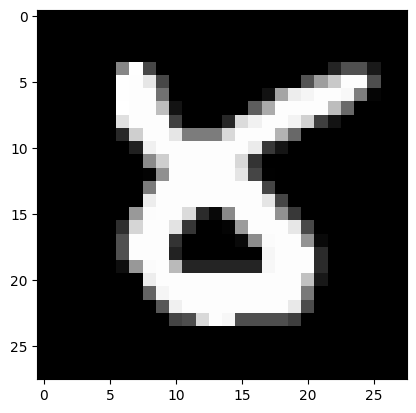

8


In [22]:
show_image(25069, dataset='train')
print(dataset_train[25069][1])

In [16]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [37]:
def remove_element_from_dataset(dataset, remove_index):
    # Get the list of all indices except the one to be removed
    indices = list(range(len(dataset)))
    indices.pop(remove_index)

    # Create a new dataset as a subset using the remaining indices
    new_dataset = Subset(dataset, indices)

    return new_dataset

def leave_one_out_retrain(z_test, z_test_label, old_model, top_influential=top_influential_dict):
  loss_fn = nn.CrossEntropyLoss()
  # compute old test loss
  old_model.eval()
  with torch.no_grad():
    old_loss = loss_fn(old_model(z_test), torch.tensor([z_test_label], dtype=torch.long))
  print("Old test loss: ", old_loss.item())

  change_in_test_loss = []

  count = 0
  for idx, val in top_influential.items():
    new_train_dataset = remove_element_from_dataset(dataset_train, remove_index=idx)
    new_train_loader = DataLoader(dataset=new_train_dataset, batch_size=16, shuffle=False)

    count += 1
    print("Retraining model #", count, " (idx=", idx, ")")

    torch.manual_seed(42)
    new_model = LogisticRegressionMnist()
    new_model.load_state_dict(torch.load('model_state_dict.pth'))
    train(new_model, 9, 0.01, new_train_loader) # ~30k steps

    with torch.no_grad():
      new_loss = loss_fn(new_model(z_test), torch.tensor([z_test_label], dtype=torch.long))
    change_in_test_loss.append(new_loss.item() - old_loss.item())
    print()
    print("Change in test loss: ", change_in_test_loss[-1])
    print()

  return change_in_test_loss

In [38]:
change_in_test_loss = leave_one_out_retrain(z_test, z_test_label, model)
# print(change_in_test_loss)

Old test loss:  5.6112260818481445
Retraining model # 1  (idx= 22849 )


<ipython-input-37-66c159660f2d>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('model_state_dict.pth'))


Epoch 1/9, Loss: 0.29882249437541275
Epoch 2/9, Loss: 0.2983287484301097
Epoch 3/9, Loss: 0.298038080387758
Epoch 4/9, Loss: 0.2978622298205511
Epoch 5/9, Loss: 0.2977539240444917
Epoch 6/9, Loss: 0.29768627547778714
Epoch 7/9, Loss: 0.29764353630683965
Epoch 8/9, Loss: 0.2976162602465086
Epoch 9/9, Loss: 0.2975987336555536

Change in test loss:  0.04441213607788086

Retraining model # 2  (idx= 22513 )
Epoch 1/9, Loss: 0.29888889365875576
Epoch 2/9, Loss: 0.29839714185387295
Epoch 3/9, Loss: 0.29810679822709407
Epoch 4/9, Loss: 0.29793113572040814
Epoch 5/9, Loss: 0.29782296759100796
Epoch 6/9, Loss: 0.29775540094384884
Epoch 7/9, Loss: 0.2977127139876451
Epoch 8/9, Loss: 0.2976854883704319
Epoch 9/9, Loss: 0.2976679779034392

Change in test loss:  0.026731014251708984

Retraining model # 3  (idx= 44398 )
Epoch 1/9, Loss: 0.2988666357459536


KeyboardInterrupt: 

In [39]:
def leave_one_out_retrain_single(z_test, z_test_label, old_model, idx):
  loss_fn = nn.CrossEntropyLoss()
  # compute old test loss
  old_model.eval()
  with torch.no_grad():
    old_loss = loss_fn(old_model(z_test), torch.tensor([z_test_label], dtype=torch.long))
  print("Old test loss: ", old_loss.item())

  change_in_test_loss = []

  count = 0

  new_train_dataset = remove_element_from_dataset(dataset_train, remove_index=idx)
  new_train_loader = DataLoader(dataset=new_train_dataset, batch_size=16, shuffle=False)

  count += 1
  print("Retraining model #", count, " (idx=", idx, ")")

  torch.manual_seed(42)
  new_model = LogisticRegressionMnist()
  new_model.load_state_dict(torch.load('model_state_dict.pth'))
  train(new_model, 9, 0.01, new_train_loader) # ~30k steps

  with torch.no_grad():
    new_loss = loss_fn(new_model(z_test), torch.tensor([z_test_label], dtype=torch.long))
  change_in_test_loss.append(new_loss.item() - old_loss.item())
  print()
  print("Change in test loss: ", change_in_test_loss[-1])
  print()

  return change_in_test_loss

In [40]:
leave_one_out_retrain_single(z_test, z_test_label, model, 25069)

Old test loss:  5.6112260818481445
Retraining model # 1  (idx= 25069 )


<ipython-input-39-982c1776fdc4>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('model_state_dict.pth'))


Epoch 1/9, Loss: 0.29882508051679746
Epoch 2/9, Loss: 0.2983280457810885
Epoch 3/9, Loss: 0.2980363943709961
Epoch 4/9, Loss: 0.2978601876701542
Epoch 5/9, Loss: 0.297751729473593
Epoch 6/9, Loss: 0.2976839892266057
Epoch 7/9, Loss: 0.2976411914977355
Epoch 8/9, Loss: 0.29761388727126253
Epoch 9/9, Loss: 0.2975963288549726

Change in test loss:  0.009134769439697266



[0.009134769439697266]

In [ ]:
# plot scatter plot between actual diff in loss and predicted diff in loss
actual_diff_in_loss = [x.item() for x in change_in_test_loss]
predicted_diff_in_loss = [(-1/len(dataset_train))* x for x in top_influential_dict.values()]


plt.scatter(actual_diff_in_loss, predicted_diff_in_loss)

# plot a line of best fit
m, b = np.polyfit(actual_diff_in_loss, predicted_diff_in_loss, 1)
plt.plot(actual_diff_in_loss, m*np.array(actual_diff_in_loss) + b, color='gray')
plt.xlabel("Actual diff in loss")
plt.ylabel("Predicted diff in loss")